In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -u "/content/drive/My Drive/archive (2).zip" -d "/content/drive/My Drive/dataset"

Archive:  /content/drive/My Drive/archive (2).zip
  inflating: /content/drive/My Drive/dataset/house_legislation_116.csv  
  inflating: /content/drive/My Drive/dataset/house_members_116.csv  
  inflating: /content/drive/My Drive/dataset/house_rollcall_info_116.csv  
  inflating: /content/drive/My Drive/dataset/house_rollcall_votes_116.csv  


In [ ]:
from ast import literal_eval
import pandas as pd
import networkx as nx
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import community
from collections import defaultdict

In [ ]:
members = pd.read_csv('/content/drive/My Drive/dataset/house_members_116.csv', index_col = 0)

members.committee_assignments = members.committee_assignments.apply(literal_eval)

members.head()

,name,state,url,chamber,current_party,committee_assignments
name_id,,,,,,
A000374,ralph-abraham,Louisiana,https://www.congress.gov/member/ralph-abraham/...,House,Republican,"[Agriculture, Armed Services]"
A000370,alma-adams,North Carolina,https://www.congress.gov/member/alma-adams/A00...,House,Democratic,"[Agriculture, Education and Labor, Financial S..."
A000055,robert-aderholt,Alabama,https://www.congress.gov/member/robert-aderhol...,House,Republican,[Appropriations]
A000371,pete-aguilar,California,https://www.congress.gov/member/pete-aguilar/A...,House,Democratic,"[Appropriations, House Administration]"
A000372,rick-allen,Georgia,https://www.congress.gov/member/rick-allen/A00...,House,Republican,"[Agriculture, Education and Labor]"


In [ ]:
bills = pd.read_csv('/content/drive/My Drive/dataset/house_legislation_116.csv', index_col = 0, parse_dates=["date_introduced"])

bills.cosponsors=bills.cosponsors.apply(literal_eval)
bills.subjects = bills.subjects.apply(literal_eval)
bills.committees = bills.committees.apply(literal_eval)
bills.related_bills = bills.related_bills.apply(literal_eval)

bills.head()

,title,sponsor,cosponsors,related_bills,policy_area,subjects,committees,bill_progress,summary,date_introduced,number,bill_type
bill_id,,,,,,,,,,,,
H.R.1,"To expand Americans' access to the ballot box,...",S001168,"[P000197, A000370, A000376, B001300, B001281, ...","[H.R.44, H.R.93, H.R.137, H.R.138, H.R.196, H....",Government Operations and Politics,"[Administrative law and regulatory procedures,...","[House Administration, House Intelligence (Per...",Passed House,"This bill addresses voter access, election int...",2019-01-03,1,H.R.
H.R.3,"To establish a fair price negotiation program,...",P000034,"[N000015, S000185, L000557, K000382, D000197, ...","[H.R.4619, H.R.4649, H8607, H.R.4663]",Health,[],"[House Energy and Commerce, House Ways and Mea...",Introduced,This bill establishes several programs and req...,2019-09-19,3,H.R.
H.R.4,To amend the Voting Rights Act of 1965 to revi...,S001185,"[L000287, P000197, H000874, C000537, L000570, ...","[H.R.1799, S.561]",Government Operations and Politics,"[Civil actions and liability, Elections, votin...",[House Judiciary],Introduced,NaN,2019-02-26,4,H.R.
H.R.5,To prohibit discrimination on the basis of sex...,C001084,"[F000466, C001119, D000629, H001087, M001185, ...","[H.Res.377, S.788]","Civil Rights and Liberties, Minority Issues","[Civil actions and liability, Consumer credit,...","[House Judiciary, House Education and Labor, H...",Passed House,This bill prohibits discrimination based on se...,2019-03-13,5,H.R.
H.R.6,To authorize the cancellation of removal and a...,R000486,"[V000081, C001067, A000371, B001300, C001112, ...","[H.R.2820, H.R.2821, H.Res.415, S.874]",Immigration,"[Administrative law and regulatory procedures,...","[House Judiciary, House Education and Labor]",Passed House,This bill cancels and prohibits removal procee...,2019-03-12,6,H.R.


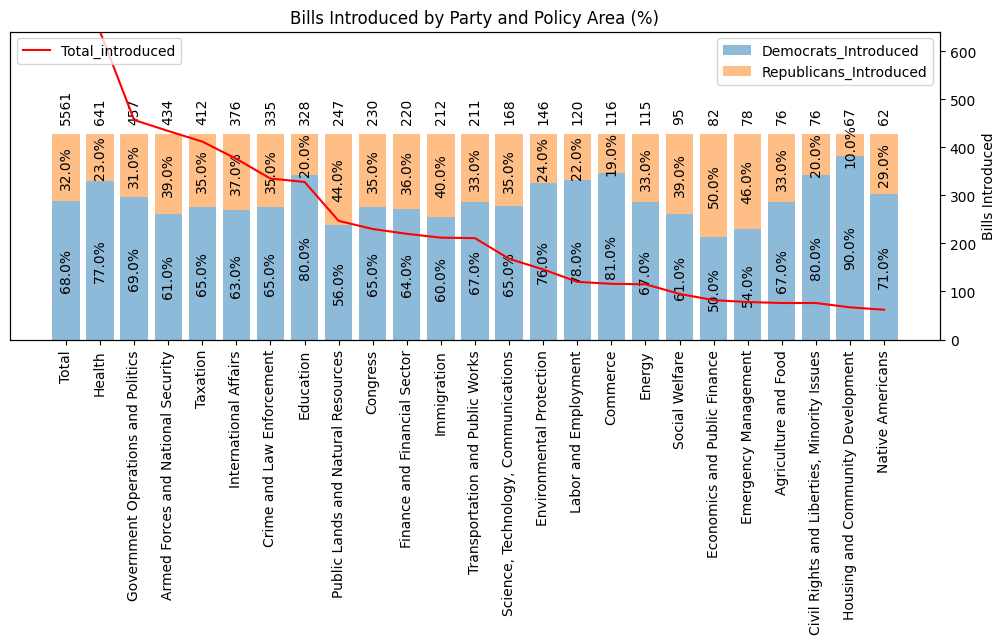

In [ ]:
#areas: list of unique policy areas in bills
areas = bills.policy_area.unique()

#dic: dictionary with keys corresponding to unique policy areas with values initialized to 0
dic = {area: [0,0,0,0] for area in areas}


#iterate through bills and tally the bills by policy area
for index, row in bills.iterrows():
    #capture bills that were introduced by Democrats
    if members.loc[row.sponsor].current_party == 'Democratic':
        dic[row.policy_area][0] += 1
        #capture bills passed by Democrats
        if row.bill_progress == ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate'):
                dic[row.policy_area][1]+=1
    #capture bills introduced by Republicans
    elif members.loc[row.sponsor].current_party == 'Republican':
        dic[row.policy_area][2] += 1
        #capture bills passed by Republicans
        if row.bill_progress == ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate'):
                dic[row.policy_area][3]+=1

#create dataframe from dictionary with rows representing policy_areas and columns representing bills introduced/passed by Democrats and Republicans
df = pd.DataFrame(dic.values(), index = dic.keys(), columns = ['Democratic', 'Democrats_Passed','Republican', 'Republicans_Passed']).sort_values('Democratic', ascending = False)

df.drop(np.nan, inplace = True)

#add row for 'Total' representing all bills regardless of policy area
df.loc['Total'] = [sum(df[x]) for x in df.columns]

#add column 'Total'representing the total bills introduced by policy area
df['Total'] = df.Democratic +df.Republican

#add column 'Total_Passed' represengint the total bills passed by policy area
df['Total_Passed'] = df.Democrats_Passed+df.Republicans_Passed

#add columns representing percentages of bills passed/introduced by Democrats, Republicans and overall
df['D%_passed']=df.Democrats_Passed/df.Total_Passed
df['R%_passed']=df.Republicans_Passed/df.Total_Passed
df['D%_introduced'] = df['Democratic']/df['Total']
df['R%_introduced'] = df['Republican']/df['Total']
df['%_passed'] = 100*(df['Total_Passed']/df['Total'])

#fill nan values with 0
df.fillna(0, inplace=True)

#sort df by total introduced by policy area
df.sort_values(by=['Total'], ascending = False, inplace= True)

#limits the plots to the 25 most prolific polify areas as measured by number of bills introduced in the policy area
n=25
x= df.head(n).index
y1= df.head(n)['D%_introduced']
y2= df.head(n)['R%_introduced']
total = df.head(n)['Total']

#creates two subplots one for bills introduced and one for bills passed
fig, (ax1) = plt.subplots(nrows =1, ncols =1, figsize=(12, 4), squeeze = True)

#plot democrats/republican_introduced on ax1
ax1.bar(x, y1, label='Democrats_Introduced', alpha = .5)
ax1.bar(x, y2 ,bottom= y1,label= 'Republicans_Introduced', alpha = .5)


# add text annotation corresponding to the percentages introduced in each policy by Republicans and Democrats.
for xpos, ypos, yval in zip(x, y1/2, y1):
    if yval>0:
        ax1.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation=90)
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    if yval>0:
        ax1.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation= 90)
# add text annotation corresponding to the number of total bills introduced in each policy area
for xpos, ypos, total in zip(x, y1+y2, total):
    ax1.text(xpos, ypos +.05, total, ha="center", va="bottom", rotation= 90)

#rotate x_tick labels 90 degrees for ax1
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

#set title and legend for ax1
ax1.set_title('Bills Introduced by Party and Policy Area (%)')
ax1.legend(loc = 'upper right')

#set y_lim for ax1 and hide the y-axis of ax1
ax1.set_ylim(0,1.5)
ax1.yaxis.set_visible(False)

#create a second y-axis on the first subplot ax3
ax3 = ax1.twinx()
#plot a line graph for total introduced by policy area using ax3
ax3.plot(x, df.head(n).Total, color = 'red', label = 'Total_introduced')
ax3.set_ylim(0,641)
ax3.legend(loc = 'upper left')
ax3.yaxis.set_visible(True)
ax3.set_ylabel('Bills Introduced')

#show plot
plt.show()

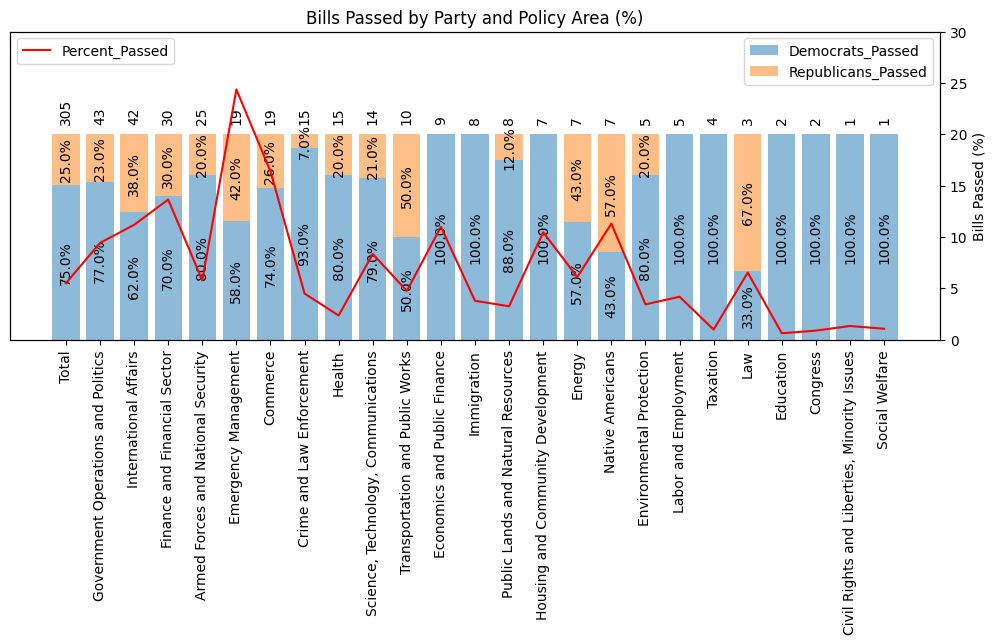

In [ ]:
fig, (ax2) = plt.subplots(nrows =1, ncols =1, figsize=(12, 4), squeeze = True)

#resort df by total passed by policy area
df.sort_values(by=['Total_Passed'], ascending = False, inplace= True)

#limits plot to the 25 most prolific policy areas as measured by the total number of bills passed
x= df.head(n).index
y1= df.head(n)['D%_passed']
y2= df.head(n)['R%_passed']
y3= df.head(n)['Democratic']+ df.head(n)['Republican']
total = df.head(n)['Total_Passed']

#plot bars representing the number of bills passed by Democrats/Republicans by policy area
ax2.bar(x, y1, label='Democrats_Passed', alpha=.5)
ax2.bar(x, y2 ,bottom= y1,label= 'Republicans_Passed', alpha=.5)

#create a second axis on the second subplot for a line plot representing the percentage of bills pased by policy area
ax4 = ax2.twinx()
ax4.plot(x, df.head(n)['%_passed'], color = 'red', label = 'Percent_Passed')
ax4.set_ylim(0,30)
ax4.legend(loc = 'upper left')
ax4.yaxis.set_visible(True)
ax4.set_ylabel("Bills Passed (%)")

# add text annotation corresponding to the percentage passed by Democrats and Republicans.
for xpos, ypos, yval in zip(x, y1/2, y1):
    if yval>0:
        ax2.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation=90)
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    if yval>0:
        ax2.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation= 90)
# add text annotation corresponding to the total number of bills passed in each policy area
for xpos, ypos, total in zip(x, y1+y2, total):
    ax2.text(xpos, ypos +.05, total, ha="center", va="bottom", rotation= 90)

#rotate xlabels 90 degrees on second subplot
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
#set title legend for ax2
ax2.set_title('Bills Passed by Party and Policy Area (%)')
ax2.legend(loc = 'upper right')

#set y limit and y_axis visibiity for ax2
ax2.set_ylim(0,1.5)
ax2.yaxis.set_visible(False)


#show plot
plt.show()

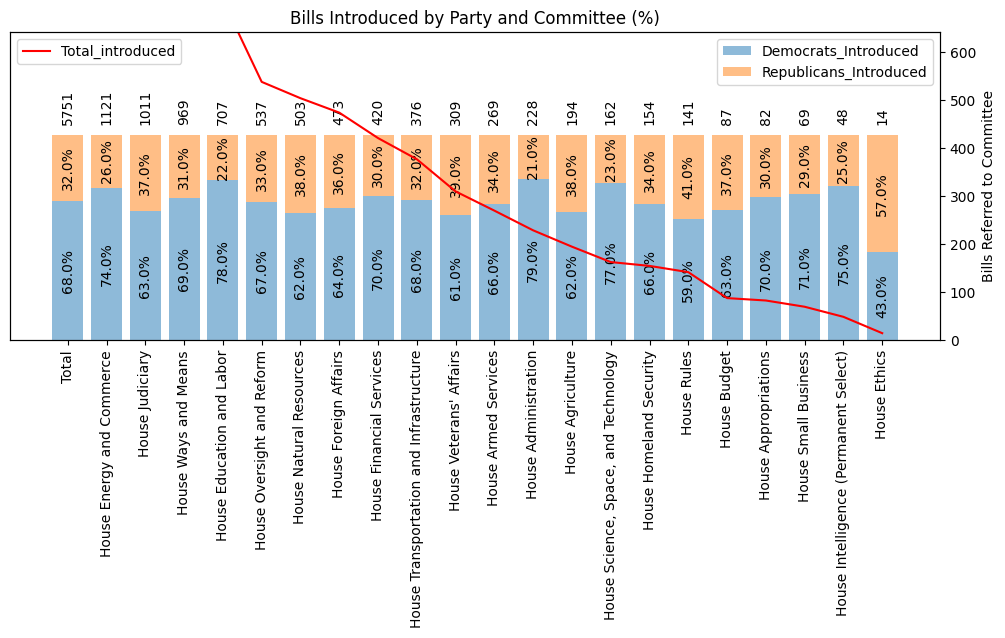

In [ ]:
#committees: list of unique committees in the House of Representatives
committees =[]
Dems=[]
Reps=[]
D_passed = []
R_passed = []

#iterate through bills and append unique House committees to list: committees
for bill, row in bills.iterrows():
    for committee in row.committees:
        if (committee not in committees) and ('House' in committee):
            committees.append(committee)


#dic: dictionary with keys corresponding to unique committees with values initialized to 0
dic = {committee: [0,0,0,0] for committee in committees}


#iterate through bills and based on committees
for index, row in bills.iterrows():
    #iterate through committees associated with bill
    for committee in row.committees:
        #only consider House committees, exclude Senate committees
        if ('House' in committee):
            if members.loc[row.sponsor].current_party == 'Democratic':
                #capture bills referrered to committee that are sponsored by Democrats
                dic[committee][0] += 1
                #capture bill name
                if index not in Dems:
                    Dems.append(index)
                #capture bills referred to committee sponsored by Democrats that have passed the House
                if row.bill_progress == ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate'):
                    dic[committee][1]+=1
                    #capture bill name
                    if index not in D_passed:
                        D_passed.append(index)


            elif members.loc[row.sponsor].current_party == 'Republican':
                #capture bills referred to committee that were sponsored by Republicans
                dic[committee][2] += 1
                #capture bill name
                if index not in Reps:
                    Reps.append(index)
                #capture bills referred to committee that were sponsored by Republicans which passed the House
                if row.bill_progress == ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate'):
                    dic[committee][3]+=1
                    if index not in R_passed:
                        R_passed.append(index)


#create Dataframe: df from dic with rows representing House committees and columns representing bills introduced/passed by Democrats or Republicans
df = pd.DataFrame(dic.values(), index = dic.keys(), columns = ['Democratic', 'Democrats_Passed','Republican', 'Republicans_Passed']).sort_values('Democratic', ascending = False)

#add row representing all bills regardless of committee to which they were referred
df.loc['Total'] = [len(Dems), len(D_passed), len(Reps), len(R_passed)]

# add column 'Total' representing all bills introduced regardless of the party of the bill sponsor
df['Total'] = df.Democratic +df.Republican

# add column 'Total_Passed' representing all bills passed regardless of the party of the bill sponsor
df['Total_Passed'] = df.Democrats_Passed+df.Republicans_Passed

#add percentage columns
df['D%_passed']=df.Democrats_Passed/df.Total_Passed
df['R%_passed']=df.Republicans_Passed/df.Total_Passed
df['D%_introduced'] = df['Democratic']/df['Total']
df['R%_introduced'] = df['Republican']/df['Total']
df['%_passed'] = 100*(df['Total_Passed']/df['Total'])

#fill nan values with 0
df.fillna(0, inplace=True)

#sort df by 'Total' column
df.sort_values(by=['Total'], ascending = False, inplace= True)


n=25
x= df.head(n).index

y1= df.head(n)['D%_introduced']
y2= df.head(n)['R%_introduced']

total = df.head(n)['Total']



fig, (ax1) = plt.subplots(nrows =1, ncols =1, figsize=(12, 4), squeeze = True)


ax1.bar(x, y1, label='Democrats_Introduced', alpha = .5)
ax1.bar(x, y2 ,bottom= y1,label= 'Republicans_Introduced', alpha = .5)


# add text annotation corresponding to the values of each bar.
for xpos, ypos, yval in zip(x, y1/2, y1):
    if yval>0:
        ax1.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation=90)
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    if yval>0:
        ax1.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation= 90)
# add text annotation corresponding to the "total" value of each bar
for xpos, ypos, total in zip(x, y1+y2, total):
    ax1.text(xpos, ypos +.05, total, ha="center", va="bottom", rotation= 90)

#rotate tick labels to 90 degrees
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

#set title and legend for first subplot
ax1.set_title('Bills Introduced by Party and Committee (%)')
ax1.legend(loc = 'upper right')

#set y_lim and y_axis visibility
ax1.set_ylim(0,1.5)
ax1.yaxis.set_visible(False)

#add second y_axis to first subplot
ax3 = ax1.twinx()

#plot line graph representing total bills referred to each committee
ax3.plot(x, df.head(n).Total, color = 'red', label = 'Total_introduced')
ax3.set_ylim(0,641)
ax3.legend(loc = 'upper left')
ax3.yaxis.set_visible(True)
ax3.set_ylabel('Bills Referred to Committee')


#show plot
plt.show()

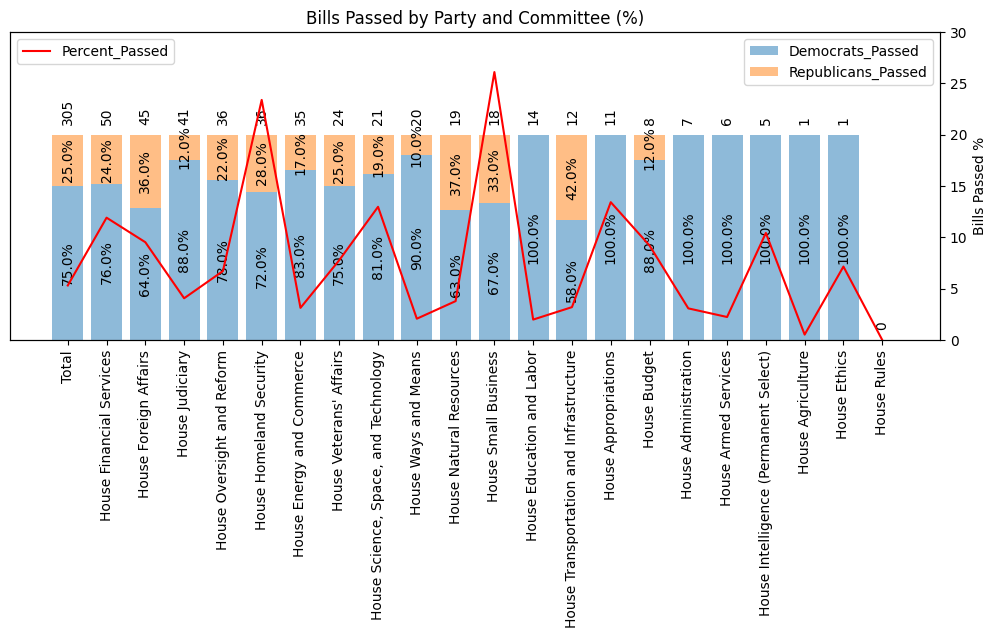

In [ ]:
fig, (ax2) = plt.subplots(nrows =1, ncols =1, figsize=(12, 4), squeeze = True)


#sort df by total bills passed by committee
df.sort_values(by=['Total_Passed'], ascending = False, inplace= True)

#limits plot to the top 25 committees
x= df.head(n).index

#calculate passage percentages
y1= df.head(n)['D%_passed']
y2= df.head(n)['R%_passed']
y3= df.head(n)['Democratic']+ df.head(n)['Republican']
total = df.head(n)['Total_Passed']

#plot bar graph for second subplot for bills bassed by committee
ax2.bar(x, y1, label='Democrats_Passed', alpha=.5)
ax2.bar(x, y2 ,bottom= y1,label= 'Republicans_Passed', alpha=.5)

#create second second y_axis for the second subplot for line plot
ax4 = ax2.twinx()

#plot line plot for number of bills passed by committee
ax4.plot(x, df.head(n)['%_passed'], color = 'red', label = 'Percent_Passed')

#set y_limit, legebd location, visibility and label for the ax4
ax4.set_ylim(0,30)
ax4.legend(loc = 'upper left')
ax4.yaxis.set_visible(True)
ax4.set_ylabel('Bills Passed %')

# add text annotation corresponding to the percentages of bills passed that were referred to each committee by Democrats or Republicans
for xpos, ypos, yval in zip(x, y1/2, y1):
    if yval>0:
        ax2.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation=90)
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    if yval>0:
        ax2.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation= 90)

# add text annotation corresponding to the number of bills passed that were also referred to each of the different committees
for xpos, ypos, total in zip(x, y1+y2, total):
    ax2.text(xpos, ypos +.05, total, ha="center", va="bottom", rotation= 90)

#rotate x_tick labels by 90 degrees
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

#set title and legend location for the second subplot
ax2.set_title('Bills Passed by Party and Committee (%)')
ax2.legend(loc = 'upper right')

#set y limit and y_axis visibiity for ax2
ax2.set_ylim(0,1.5)
ax2.yaxis.set_visible(False)

plt.show()


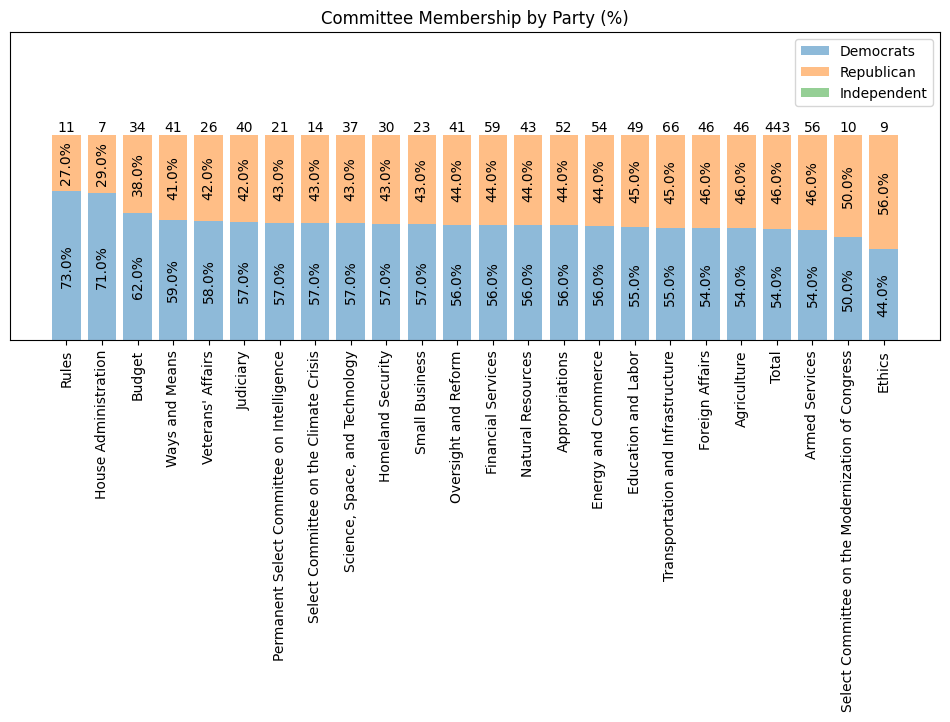

In [ ]:
fig, (ax5) = plt.subplots(nrows =1, ncols =1, figsize=(12, 4), squeeze = True)

#committees: list of unique committees in the House of Representatives
committees =[]

#iterate through members dataframe to capture all unique committees
for member, row in members.iterrows():
    #iterate through each committee assignment for each member
    for committee in row.committee_assignments:
        #capture committee if not already within list committees
        if (committee not in committees):
            committees.append(committee)

#create dictionary having keys corresponding to values in list committees
dic = {committee: [0,0,0] for committee in committees}


#iterate through dataframe members and tally the number of Democrats and Republicans in each committee
for index, row in members.iterrows():
    #iterate through committee assignments for each member
    for committee in row.committee_assignments:
        #for each committee in dic add 1 to the 1st value of the list if member is a Democrat
        if row.current_party == 'Democratic':
            dic[committee][0] += 1
        # else add 1 to the 2nd value of the list if member is a Democrat
        elif row.current_party == 'Republican':
            dic[committee][1] += 1
        # otherwise add 1 to the 3rd value of the list to capture independents
        else:
            dic[committee][2] += 1


#count: series storing the total number of Democrats, Republicans and Independents in the House
count = members.groupby('current_party').count().name

# df: dataframe storing the number of Democrats, Republicans and Independents in each committee
df = pd.DataFrame(dic.values(), index = dic.keys(), columns = ['Democratic', 'Republican', 'Independent']).sort_values(by = 'Democratic', ascending = False).head(23)

#add row to df for total number of Democrats, Republicans and Independents in the House
df.loc['Total'] = [count.loc['Democratic'],  count.loc['Republican'], count.loc['Independent']]

#add column to df representng the total number of members of each committee
df['Total'] = df['Democratic']+df['Republican']+df['Independent']

#add columns representing fraction of each of the parties by committee
df['D%'] = df['Democratic']/df['Total']
df['R%'] = df['Republican']/df['Total']
df['I%'] = df['Independent']/df['Total']

#sort df in descending order by the percentage of Democrats within each committee
df.sort_values(by='D%', ascending = False, inplace= True)

#define variables for plotting and annotations
n=25
x= df.head(n).index
y1= df.head(n)['D%']
y2= df.head(n)['R%']
y3= df.head(n)['I%']
total = df.head(n)['Total']


#Plot bars for Democrats, Republicans and Independents with shared axis ax5
ax5.bar(x, y1, label='Democrats', alpha=.5)
ax5.bar(x, y2 ,bottom= y1,label= 'Republican', alpha=.5)
ax5.bar(x, y3 ,bottom= y1+y2,label= 'Independent', alpha=.5)

# add text annotation corresponding to the values of each bar.
for xpos, ypos, yval in zip(x, y1/2, y1):
    ax5.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation=90)
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    ax5.text(xpos, ypos, str(round(yval*100,0))+ "%", ha="center", va="center", rotation= 90)

# add text annotation corresponding to the "total" value of each bar
for xpos, ypos, total in zip(x, y1+y2, total):
    ax5.text(xpos, ypos, total, ha="center", va="bottom",)

#set y_limit
ax5.set_ylim(0,1.5)

#rotate x_tick labels by 90 degrees
for tick in ax5.get_xticklabels():
    tick.set_rotation(90)

#set title, legend location and y_axis visibility
ax5.set_title('Committee Membership by Party (%)')
ax5.legend(loc = 'upper right')
ax5.yaxis.set_visible(False)

#show plot
plt.show()

In [ ]:
# dic: with keys corresponding to members_ids from members dataframe and list for storing count of bills introduced and passed by a member
dic = {k:[0,0] for k in members.index}

#iterrate through bills and add count number of bills introduced/passed by each member
for index, row in bills.iterrows():
    dic[row.sponsor][1]+=1
    if row.bill_progress == ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate'):
        dic[row.sponsor][0]+=1

#num_passed: dataframe created from dic with index correpodning to member_id and columns representing the number of bills introduced/passed by eac member
num_passed = pd.DataFrame.from_dict(dic, orient = 'index',columns = ['num_passed', 'total_introduced'])

#create column for percentage of bills passed by each member
num_passed['percent_passed'] =( num_passed['num_passed']/num_passed['total_introduced'])*100

#sort num_passed
num_passed.sort_values(by = ['num_passed','percent_passed'], ascending = False, inplace = True)

#merge num_passed with members dataframe
num_passed.merge(members[['name', 'current_party', 'committee_assignments']], how = 'inner', left_index= True, right_index =True).head(10)

,num_passed,total_introduced,percent_passed,name,current_party,committee_assignments
E000179,9,53,16.981132,eliot-engel,Democratic,"[Foreign Affairs, Chair, Energy and Commerce]"
C000984,5,32,15.625000,elijah-cummings,Democratic,"[Oversight and Reform, Chair, Transportation a..."
J000032,5,37,13.513514,sheila-jackson-lee,Democratic,"[Budget, Homeland Security, Judiciary]"
T000193,4,16,25.000000,bennie-thompson,Democratic,"[Homeland Security, Chair]"
J000126,4,19,21.052632,eddie-johnson,Democratic,"[Science, Space, and Technology, Chair, Transp..."
R000602,4,19,21.052632,kathleen-rice,Democratic,"[Homeland Security, Veterans' Affairs]"
M001157,4,23,17.391304,michael-mccaul,Republican,"[Foreign Affairs, Homeland Security]"
L000480,4,24,16.666667,nita-lowey,Democratic,"[Appropriations, Chair]"
L000588,3,9,33.333333,conor-lamb,Democratic,"[Science, Space, and Technology, Veterans' Aff..."
W000825,3,9,33.333333,jennifer-wexton,Democratic,"[Financial Services, Science, Space, and Techn..."


In [ ]:
#set policy_area to focus on for second part of analysis
policy_area = 'Crime and Law Enforcement'


# MD: graph with directed edges from bill cosponsors to a bill sponsor
MD = nx.MultiDiGraph()
MD.add_nodes_from(members.index)
for index, row in bills.iterrows():
    sponsor = [row.sponsor for i in range(len(row.cosponsors))]
    zipped = zip(row.cosponsors, sponsor)
    zipped = list(zipped)

    #set edge attribute related to bill policy_area
    MD.add_edges_from(zipped, bill = index, policy_area = row.policy_area, bill_progress = row.bill_progress)

#drop nodes representing non-voting members, former members and the Speaker of the House
to_drop =['G000582', 'R000600', 'N000147', 'P000610', 'S001177', 'S001204', 'P000197', 'J000255']
MD.remove_nodes_from(to_drop)

# set node attrbute 'party'
nx.set_node_attributes(MD,  members.current_party.to_dict(), 'party')


#convert MD from a multi-directed graph to graph with weighted edges, with weights representing the number of edges between two nodes
G = nx.Graph()

for n, nbrs in MD.adjacency():
    for nbr, edict in nbrs.items():
        if (G.has_edge(n,nbr)) :
            G[n][nbr]['weight'] +=len(edict)
        else:
             G.add_edge(n, nbr, weight=len(edict))

#MDs: subgraph limited to edges filtered by a policy area == 'Crime and Law Enforcement'
MDs = nx.MultiDiGraph()

for u,v,d in MD.edges(data = True):
    if d['policy_area'] ==  policy_area:
        MDs.add_edge(u,v,bill = d['bill'])


#convert MDs from a multi-directed graph to graph with weighted edges, with weights representing the number of edges between the nodes
Gs = nx.Graph()

for n, nbrs in MDs.adjacency():
    for nbr, edict in nbrs.items():
        if (Gs.has_edge(n,nbr)) :
            Gs[n][nbr]['weight'] +=len(edict)
        else:
             Gs.add_edge(n, nbr, weight=len(edict))

In [ ]:
!pip uninstall community
import community.community_louvain as cl

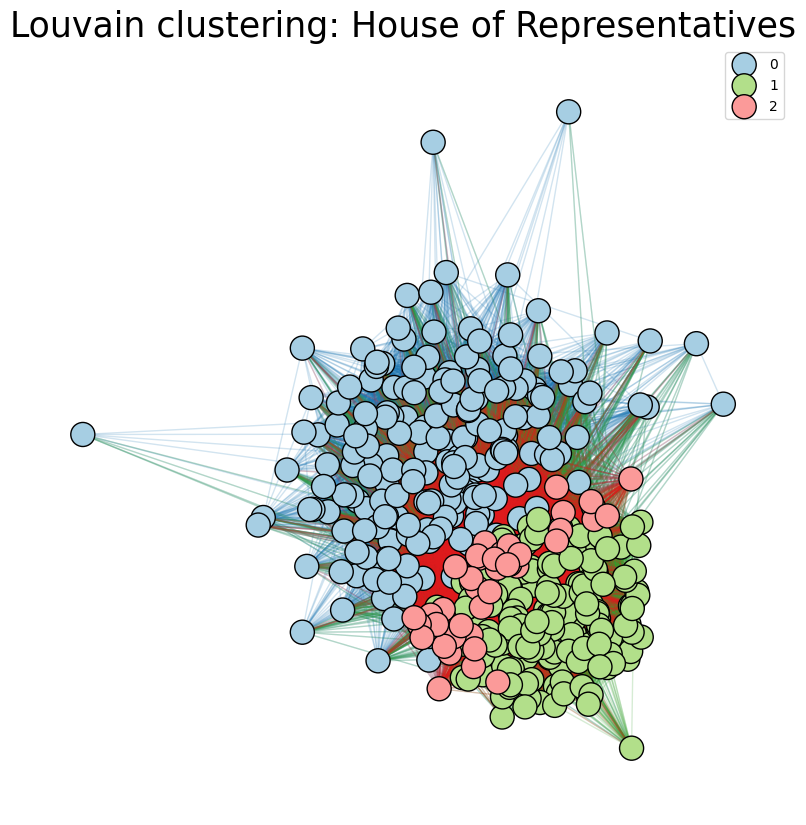

In [ ]:
def get_paired_color_palette(size):
    palette = []
    for i in range(size*2):
        palette.append(plt.cm.Paired(i))
    return palette


#use louvain community detection algorithm to detect communities in G
communities =[]
louvain = cl.best_partition(G, weight = 'weight', random_state=42)
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    communities.append(nodelist)

#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)[0::2]
dark_colors = get_paired_color_palette(clusters_count)[1::2]
g = nx.drawing.layout.spring_layout(G, weight = 'weight', seed = 42, threshold = .0000000001)

#iterate through each of the communities found by the Louvain algorithm and plot
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.2, edge_color=edge_color)

#set title, legend and show plot
plt.title('Louvain clustering: House of Representatives', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
# instantiate dictionaries
community_members = defaultdict()
community_bills = defaultdict()

# iterate through each community found by Louvain algorithm
for i in range(3):
    dic ={}
    index = []
    #set community_of_interest
    community_of_interest = i

    #create subgraph with nodes limited to the community_of_interest
    subgraph = MD.subgraph(communities[community_of_interest])

    #create dataframe for each community with index corresponding to member_id and a column representing the in_degree centrality of each member, merge with members dataframe
    community_members[i] = pd.DataFrame.from_dict(nx.algorithms.centrality.in_degree_centrality(subgraph), orient = 'index', columns = ['centrality']).merge(members[['name','current_party', 'committee_assignments']], how = 'left', left_index = True, right_index = True).sort_values(by= 'centrality',ascending = False)


    # community_bills[i] is a subset of bills dataframe having a sponsor within the given community i
    community_bills[i] = bills.loc[[row.sponsor in communities[i] for index, row in bills.iterrows()]]

    # iterate through community_bills[i]
    for bill, row in community_bills[i].iterrows():
        #append bill to list index
        index.append(bill)
        #create dic key related to each bill and set initial value to 0
        dic[bill] = 0
        #iterate through cosponsors of each bill
        for cosponsor in row.cosponsors:
            #count number of bill cosponsors which are within the given community
            if cosponsor in community_members[i].index:
                dic[bill] += 1



    #create data frame from dic with bill as index and column representing the number of in_community cosponsor for each bill
    tally = pd.DataFrame.from_dict(dic, orient = 'index',columns = ['in_community_cosponsors'])

    #merge tally with community_bills[i]
    community_bills[i] = tally.merge(community_bills[i][['title', 'bill_progress']],how = 'outer', left_index =True, right_index= True)

#instantiate lists
l = []
index = []

# iterate through each community found by Louvain algorithm
for i in range(3):
    # community_i is a subset of members limited to members of the given community
    community_i = members.loc[communities[i]]
    #democrats: stores the number of democrats within the given community
    democrats = len(community_i.loc[community_i.current_party == 'Democratic'])
    #republicans: stores the number of republicans in the given community
    republicans = len(community_i.loc[community_i.current_party == 'Republican'])
    #indepenents: stores the number of independents in teh given community
    independents = len(community_i.loc[community_i.current_party == 'Independent'])
    #total_members: is the total number of members in the given community
    total_members = len(community_i)
    #total_bills: the total number of bills introduced by members of the given community
    total_bills = len(community_bills[i])
    #bills_passed: is the total number of bills which passed the house which were introduced by members of the given community
    bills_passed = len(community_bills[i].loc[community_bills[i].bill_progress ==  ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate')])
    #append list containing all values to list l
    l.append([democrats, republicans, independents, total_members, total_bills, bills_passed])
    #append index string to list index
    index.append('community_' +str(i))


#create dataframe df from lists l and index
df = pd.DataFrame(l, columns = ['democrats', 'republicans', 'independents', 'total_members', 'total_bills', 'bills_passed'],index = index)
#caculate passage percentage for each community
df['percent_passed'] = (df['bills_passed']/df['total_bills'])*100
df.head()

,democrats,republicans,independents,total_members,total_bills,bills_passed,percent_passed
community_0,9,194,1,204,1845,74,4.01084
community_1,190,1,0,191,3187,178,5.58519
community_2,35,5,0,40,632,51,8.06962


In [ ]:
#democrats: subset of community_0 which are Democrats
democrats = members.loc[communities[0]]
democrats = democrats.loc[democrats.current_party == 'Democratic']
democrats

,name,state,url,chamber,current_party,committee_assignments
name_id,,,,,,
K000188,ron-kind,Wisconsin,https://www.congress.gov/member/ron-kind/K000188,House,Democratic,[Ways and Means]
P000258,collin-peterson,Minnesota,https://www.congress.gov/member/collin-peterso...,House,Democratic,"[Agriculture, Chair, Veterans' Affairs]"
B001287,ami-bera,California,https://www.congress.gov/member/ami-bera/B001287,House,Democratic,"[Foreign Affairs, Science, Space, and Technology]"
S001185,terri-sewell,Alabama,https://www.congress.gov/member/terri-sewell/S...,House,Democratic,"[Ways and Means, Permanent Select Committee on..."
P000613,jimmy-panetta,California,https://www.congress.gov/member/jimmy-panetta/...,House,Democratic,"[Agriculture, Budget, Ways and Means]"
G000581,vicente-gonzalez,Texas,https://www.congress.gov/member/vicente-gonzal...,House,Democratic,"[Financial Services, Foreign Affairs]"
C001122,joe-cunningham,South Carolina,https://www.congress.gov/member/joe-cunningham...,House,Democratic,"[Natural Resources, Veterans' Affairs]"
C001063,henry-cuellar,Texas,https://www.congress.gov/member/henry-cuellar/...,House,Democratic,[Appropriations]
F000468,lizzie-fletcher,Texas,https://www.congress.gov/member/lizzie-fletche...,House,Democratic,"[Science, Space, and Technology, Transportatio..."


In [ ]:
#dataframe lists subsets of communities 1 and 2 which are Republican
com_1 = members.loc[communities[1]]
com_2 = members.loc[communities[2]]

pd.concat([com_1.loc[com_1.current_party=='Republican'], com_2.loc[com_2.current_party=='Republican']], keys = [1,2])

name          state  \
  name_id                                     
1 Y000033          don-young         Alaska   
2 M001180     david-mckinley  West Virginia   
  K000210         peter-king       New York   
  F000466  brian-fitzpatrick   Pennsylvania   
  R000585           tom-reed       New York   
  K000386         john-katko       New York   

                                                         url chamber  \
  name_id                                                              
1 Y000033  https://www.congress.gov/member/don-young/Y000033   House   
2 M001180  https://www.congress.gov/member/david-mckinley...   House   
  K000210  https://www.congress.gov/member/peter-king/K00...   House   
  F000466  https://www.congress.gov/member/brian-fitzpatr...   House   
  R000585   https://www.congress.gov/member/tom-reed/R000585   House   
  K000386  https://www.congress.gov/member/john-katko/K00...   House   

          current_party                              committee_assignments  
  name_id                                                                   
1 Y000033    Republican  [Natural Resources, Transportation and Infrast...  
2 M001180    Republican                              [Energy and Commerce]  
  K000210    Republican            [Financial Services, Homeland Security]  
  F000466    Republican  [Foreign Affairs, Transportation and Infrastru...  
  R000585    Republican                                   [Ways and Means]  
  K000386    Republican  [Homeland Security, Transportation and Infrast...

In [ ]:
#dataframe lists the ten members of each community with the largest in_degree centralities
df = pd.concat([community_members[0], community_members[1], community_members[2]], keys =
         [0,1,2])

df.index.rename(['community','member'], inplace = True)

df= df.merge(num_passed, how = 'inner', left_on = 'member', right_index=True).sort_values(['community','centrality'], ascending = False)

pd.concat([df.loc[2].head(10), df.loc[1].head(10), df.loc[0].head(10)], keys =
         [2,1,0])

centrality               name current_party  \
  member                                                 
2 E000179    4.923077        eliot-engel    Democratic   
  D000610    4.282051    theodore-deutch    Democratic   
  K000210    2.435897         peter-king    Republican   
  C001078    2.410256    gerald-connolly    Democratic   
  S001190    2.410256  bradley-schneider    Democratic   
  R000602    2.153846      kathleen-rice    Democratic   
  P000096    1.794872   william-pascrell    Democratic   
  L000562    1.794872      stephen-lynch    Democratic   
  K000381    1.692308       derek-kilmer    Democratic   
  M001180    1.666667     david-mckinley    Republican   
1 C001084    6.289474    david-cicilline    Democratic   
  M000087    5.605263    carolyn-maloney    Democratic   
  C001080    5.042105           judy-chu    Democratic   
  S001175    4.857895      jackie-speier    Democratic   
  L000551    4.831579        barbara-lee    Democratic   
  S000185    4.742105       robert-scott    Democratic   
  D000216    4.678947       rosa-delauro    Democratic   
  T000460    4.168421      mike-thompson    Democratic   
  D000191    3.721053      peter-defazio    Democratic   
  B000574    3.605263    earl-blumenauer    Democratic   
0 K000188    3.054187           ron-kind    Democratic   
  B001302    3.044335         andy-biggs    Republican   
  S000522    2.344828  christopher-smith    Republican   
  S001185    1.689655       terri-sewell    Democratic   
  H001053    1.605911     vicky-hartzler    Republican   
  S001196    1.492611     elise-stefanik    Republican   
  W000795    1.428571         joe-wilson    Republican   
  S001176    1.413793      steve-scalise    Republican   
  S001195    1.334975        jason-smith    Republican   
  C001093    1.310345       doug-collins    Republican   

                                       committee_assignments  num_passed  \
  member                                                                   
2 E000179      [Foreign Affairs, Chair, Energy and Commerce]           9   
  D000610        [Ethics, Chair, Foreign Affairs, Judiciary]           3   
  K000210            [Financial Services, Homeland Security]           1   
  C001078            [Foreign Affairs, Oversight and Reform]           3   
  S001190                   [Small Business, Ways and Means]           0   
  R000602             [Homeland Security, Veterans' Affairs]           4   
  P000096                                   [Ways and Means]           1   
  L000562  [Financial Services, Oversight and Reform, Tra...           2   
  K000381  [Select Committee on the Modernization of Cong...           1   
  M001180                              [Energy and Commerce]           0   
1 C001084                       [Foreign Affairs, Judiciary]           2   
  M000087         [Financial Services, Oversight and Reform]           2   
  C001080                   [Small Business, Ways and Means]           2   
  S001175  [Armed Services, Oversight and Reform, Permane...           0   
  L000551                           [Appropriations, Budget]           0   
  S000185               [Education and Labor, Chair, Budget]           1   
  D000216                           [Appropriations, Budget]           3   
  T000460                                   [Ways and Means]           3   
  D000191         [Transportation and Infrastructure, Chair]           3   
  B000574                                   [Ways and Means]           1   
0 K000188                                   [Ways and Means]           0   
  B001302        [Judiciary, Science, Space, and Technology]           0   
  S000522                                  [Foreign Affairs]           2   
  S001185  [Ways and Means, Permanent Select Committee on...           0   
  H001053                      [Agriculture, Armed Services]           0   
  S001196  [Armed Services, Education and Labor, Permanen...           0   
  W000795                 

In [ ]:
#dataframe list the top ten members of each community with the highest number of bills passed
df = pd.concat([community_members[0], community_members[1], community_members[2]], keys =
         [0,1,2])

df.index.rename(['community','member'], inplace = True)

df= df.merge(num_passed, how = 'inner', left_on = 'member', right_index=True).sort_values(['community','num_passed','percent_passed', 'total_introduced'], ascending = False)

pd.concat([df.loc[2].head(5), df.loc[1].head(5), df.loc[0].head(5)], keys =
         [2,1,0])


centrality                name current_party  \
  member                                                  
2 E000179    4.923077         eliot-engel    Democratic   
  R000602    2.153846       kathleen-rice    Democratic   
  L000588    0.692308          conor-lamb    Democratic   
  K000386    1.384615          john-katko    Republican   
  C001078    2.410256     gerald-connolly    Democratic   
1 C000984    2.278947     elijah-cummings    Democratic   
  J000032    2.173684  sheila-jackson-lee    Democratic   
  T000193    2.305263     bennie-thompson    Democratic   
  J000126    3.063158       eddie-johnson    Democratic   
  L000480    1.589474          nita-lowey    Democratic   
0 M001157    0.945813      michael-mccaul    Republican   
  C000266    0.472906        steve-chabot    Republican   
  M001187    0.418719        mark-meadows    Republican   
  P000609    0.901478         gary-palmer    Republican   
  C001063    0.073892       henry-cuellar    Democratic   

                                       committee_assignments  num_passed  \
  member                                                                   
2 E000179      [Foreign Affairs, Chair, Energy and Commerce]           9   
  R000602             [Homeland Security, Veterans' Affairs]           4   
  L000588  [Science, Space, and Technology, Veterans' Aff...           3   
  K000386  [Homeland Security, Transportation and Infrast...           3   
  C001078            [Foreign Affairs, Oversight and Reform]           3   
1 C000984  [Oversight and Reform, Chair, Transportation a...           5   
  J000032             [Budget, Homeland Security, Judiciary]           5   
  T000193                         [Homeland Security, Chair]           4   
  J000126  [Science, Space, and Technology, Chair, Transp...           4   
  L000480                            [Appropriations, Chair]           4   
0 M001157               [Foreign Affairs, Homeland Security]           4   
  C000266       [Foreign Affairs, Judiciary, Small Business]           3   
  M001187  [Oversight and Reform, Transportation and Infr...           3   
  P000609  [Transportation and Infrastructure, Select Com...           2   
  C001063                                   [Appropriations]           2   

           total_introduced  percent_passed  
  member                                     
2 E000179                53       16.981132  
  R000602                19       21.052632  
  L000588                 9       33.333333  
  K000386                25       12.000000  
  C001078                27       11.111111  
1 C000984                32       15.625000  
  J000032                37       13.513514  
  T000193                16       25.000000  
  J000126                19       21.052632  
  L000480                24       16.666667  
0 M001157                23       17.391304  
  C000266                15       20.000000  
  M001187                28       10.714286  
  P000609                 6       33.333333  
  C001063                 6       33.333333

In [ ]:
#iterate through each community
for i in range(3):
    #sort bills introduced by each community by the number of in_community cosponsors
    community_bills[i].sort_values(by='in_community_cosponsors', ascending = False, inplace = True)
#concatenate the ten most supported bills of each community into one dataframe
pd.concat([community_bills[0].head(10), community_bills[1].head(10), community_bills[2].head(10)], keys =
         ['community_0', 'community_1', 'community_2'])

in_community_cosponsors  \
community_0 H.R.2207                        188   
            H.R.962                         185   
            H.Res.630                       177   
            H.R.2147                        167   
            H.R.553                         167   
            H.R.1175                        155   
            H.R.2423                        155   
            H.R.38                          153   
            H.Res.604                       148   
            H.R.616                         140   
community_1 H.R.1327                        190   
            H.R.1                           189   
            H.R.5                           189   
            H.R.7                           189   
            H.R.6                           188   
            H.R.8                           188   
            H.R.1980                        187   
            H.R.1396                        187   
            H.J.Res.46                      187   
            H.R.1773                        186   
community_2 H.Res.33                         38   
            H.Res.246                        38   
            H.Res.54                         37   
            H.R.724                          37   
            H.R.3195                         35   
            H.R.647                          34   
            H.R.1865                         34   
            H.Res.60                         33   
            H.R.1837                         32   
            H.R.1002                         30   

                                                                    title  \
community_0 H.R.2207    To amend the Internal Revenue Code of 1986 to ...   
            H.R.962     To amend title 18, United States Code, to proh...   
            H.Res.630   Condemning and censuring Adam Schiff, Represen...   
            H.R.2147    To amend the Internal Revenue Code of 1986 to ...   
            H.R.553     To amend title 10, United States Code, to repe...   
            H.R.1175    To amend the Internal Revenue Code of 1986 to ...   
            H.R.2423    To require the Secretary of the Treasury to mi...   
            H.R.38      To amend title 18, United States Code, to prov...   
            H.Res.604   Condemning and censuring Adam Schiff, Represen...   
            H.R.616     To implement equal protection under the 14th a...   
community_1 H.R.1327    To extend authorization for the September 11th...   
            H.R.1       To expand Americans' access to the ballot box,...   
            H.R.5       To prohibit discrimination on the basis of sex...   
            H.R.7       To amend the Fair Labor Standards Act of 1938 ...   
            H.R.6       To authorize the cancellation of removal and a...   
            H.R.8       To require a background check for every firear...   
            H.R.1980    To establish in the Smithsonian Institution a ...   
            H.R.1396    To award Congressional Gold Medals to Katherin...   
            H.J.Res.46  Relating to a national emergency declared by t...   
            H.R.1773    To award a Congressional Gold Medal, collectiv...   
community_2 H.Res.33    Expressing the sense of the House of Represent...   
            H.Res.246   Opposing efforts to delegitimize the State of ...   
            H.Res.54    Expressing the sense of the House of Represent...   
            H.R.724     To revise section 48 of title 18, United State...   
            H.R.3195    To amend title 54, United States Code, to prov...   
            H.R.647     To amend the Public Health Service Act to incr...   
            H.R.1865    To require the Secretary of the Treasury to mi...   
            H.Res.60    Expressing the sense of the House of Represent...   
            H.R.1837    To make improvements to certain defense and se...   
            H.R.1002    To amend the Animal Welfare Act to prohibit th...   

                                   bill_progress  
com

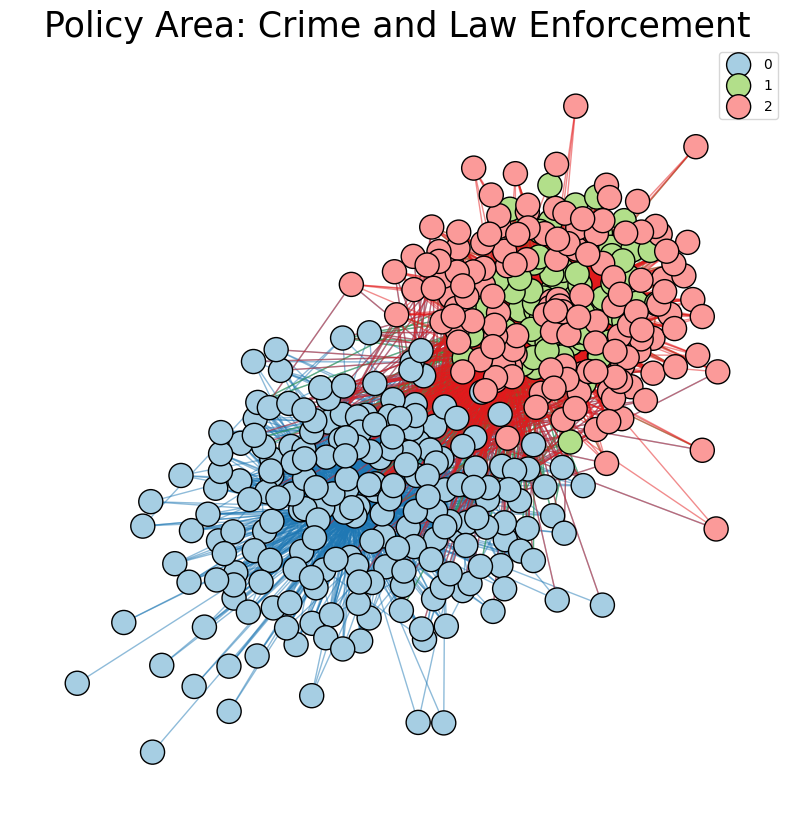

In [ ]:
# function for setting colors of nodes and edges
def get_paired_color_palette(size):
    palette = []
    for i in range(size*2):
        palette.append(plt.cm.Paired(i))
    return palette


#use louvain community detection algorithm to detect communities in Gs, network of bills limited to Crime and Law Enforcement
communities =[]
louvain = cl.best_partition(Gs, weight = 'weight', random_state=42)
for i in set(louvain.values()):
    nodelist = [n for n in Gs.nodes if (louvain[n]==i)]
    communities.append(nodelist)

#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)[0::2]
dark_colors = get_paired_color_palette(clusters_count)[1::2]
g = nx.drawing.layout.spring_layout(Gs, weight = 'weight', seed = 42, threshold = .0000000001)

#iterate through each of the communities found by the Louvain algorithm and plot
for i in set(louvain.values()):
    nodelist = [n for n in Gs.nodes if (louvain[n]==i)]
    edgelist = [e for e in Gs.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(Gs, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(Gs, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Policy Area: Crime and Law Enforcement', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
#instantiate dictionaries
community_members = defaultdict()
community_bills = defaultdict()

#iterate through communities found by Louvain algorithm
for i in range(3):
    dic ={}
    index = []
    #set community_of_interest
    community_of_interest = i

    #create subgraph with nodes limited to the community_of_interest
    subgraph = MDs.subgraph(communities[community_of_interest])

    #sort members of community_of_interest by in_degree centality
    community_members[i] = pd.DataFrame.from_dict(nx.algorithms.centrality.in_degree_centrality(subgraph), orient = 'index', columns = ['centrality']).merge(members[['name','current_party', 'committee_assignments', 'state']], how = 'left', left_index = True, right_index = True).sort_values(by= 'centrality',ascending = False)


    # Tally bills introduced by members of each community
    community_bills[i] = bills.loc[[(row.sponsor in communities[i] and row.policy_area == 'Crime and Law Enforcement') for index, row in bills.iterrows() ]]

    # iterate through community_bills[i]
    for bill, row in community_bills[i].iterrows():
        #append bill to list index
        index.append(bill)
        #create dic key related to each bill and set initial value to 0
        dic[bill] = 0
        #iterate through cosponsors of each bill
        for cosponsor in row.cosponsors:
            #count number of bill cosponsors which are within the given community
            if cosponsor in community_members[i].index:
                dic[bill] += 1



    #create data frame from dic with bill as index and column representing the number of in_community cosponsor for each bill
    tally = pd.DataFrame.from_dict(dic, orient = 'index',columns = ['in_community_cosponsors'])

    #merge tally with community_bills[i]
    community_bills[i] = tally.merge(community_bills[i][['title', 'bill_progress']],how = 'outer', left_index =True, right_index= True)


#instantiate lists
l = []
index = []

# iterate through each community found by Louvain algorithm
for i in range(3):

    # community_i is a subset of members limited to members of the given community
    community_i = members.loc[communities[i]]
    #democrats: stores the number of democrats within the given community
    democrats = len(community_i.loc[community_i.current_party == 'Democratic'])
    #republicans: stores the number of republicans in the given community
    republicans = len(community_i.loc[community_i.current_party == 'Republican'])
    #indepenents: stores the number of independents in teh given community
    independents = len(community_i.loc[community_i.current_party == 'Independent'])
    #total_members: is the total number of members in the given community
    total_members = len(community_i)
    #total_bills: the total number of bills introduced by members of the given community
    total_bills = len(community_bills[i])
    #bills_passed: is the total number of bills which passed the house which were introduced by members of the given community
    bills_passed = len(community_bills[i].loc[community_bills[i].bill_progress ==  ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate')])
    #append list containing all values to list l
    l.append([democrats, republicans, independents, total_members, total_bills, bills_passed])
    #append index string to list index
    index.append('community_' +str(i))


#create dataframe df from lists l and index
df = pd.DataFrame(l, columns = ['democrats', 'republicans', 'independents', 'total_members', 'total_bills', 'bills_passed'],index = index)
#caculate passage percentage for each community
df['percent_passed'] = (df['bills_passed']/df['total_bills'])*100
df.head()


,democrats,republicans,independents,total_members,total_bills,bills_passed,percent_passed
community_0,10,195,1,206,117,1,0.854701
community_1,76,1,0,77,111,5,4.504505
community_2,148,2,0,150,99,9,9.090909


In [ ]:
#democrats: subset of community_0 which are Democrats
democrats = members.loc[communities[0]]
democrats = democrats.loc[democrats.current_party == 'Democratic']
democrats

,name,state,url,chamber,current_party,committee_assignments
name_id,,,,,,
C001059,jim-costa,California,https://www.congress.gov/member/jim-costa/C001059,House,Democratic,"[Agriculture, Foreign Affairs, Natural Resources]"
F000468,lizzie-fletcher,Texas,https://www.congress.gov/member/lizzie-fletche...,House,Democratic,"[Science, Space, and Technology, Transportatio..."
H001083,kendra-horn,Oklahoma,https://www.congress.gov/member/kendra-horn/H0...,House,Democratic,"[Armed Services, Science, Space, and Technology]"
L000588,conor-lamb,Pennsylvania,https://www.congress.gov/member/conor-lamb/L00...,House,Democratic,"[Science, Space, and Technology, Veterans' Aff..."
B001308,anthony-brindisi,New York,https://www.congress.gov/member/anthony-brindi...,House,Democratic,"[Agriculture, Veterans' Affairs]"
C001063,henry-cuellar,Texas,https://www.congress.gov/member/henry-cuellar/...,House,Democratic,[Appropriations]
P000258,collin-peterson,Minnesota,https://www.congress.gov/member/collin-peterso...,House,Democratic,"[Agriculture, Chair, Veterans' Affairs]"
P000616,dean-phillips,Minnesota,https://www.congress.gov/member/dean-phillips/...,House,Democratic,"[Ethics, Financial Services, Foreign Affairs]"
T000484,xochitl-torres-small,New Mexico,https://www.congress.gov/member/xochitl-torres...,House,Democratic,"[Armed Services, Homeland Security]"


In [ ]:
#subsets of members which are limited to the members of communities 1 and 2
com_1 = members.loc[communities[1]]
com_2 = members.loc[communities[2]]

#concatenate Republican members of communities 1 and 2 into a single datafame
pd.concat([com_1.loc[com_1.current_party=='Republican'], com_2.loc[com_2.current_party=='Republican']], keys = [1,2])

name         state  \
  name_id                                    
1 R000585           tom-reed      New York   
2 K000210         peter-king      New York   
  F000466  brian-fitzpatrick  Pennsylvania   

                                                         url chamber  \
  name_id                                                              
1 R000585   https://www.congress.gov/member/tom-reed/R000585   House   
2 K000210  https://www.congress.gov/member/peter-king/K00...   House   
  F000466  https://www.congress.gov/member/brian-fitzpatr...   House   

          current_party                              committee_assignments  
  name_id                                                                   
1 R000585    Republican                                   [Ways and Means]  
2 K000210    Republican            [Financial Services, Homeland Security]  
  F000466    Republican  [Foreign Affairs, Transportation and Infrastru...

In [ ]:
#concatenate members of communites 1,2 and 3 into a single dataframe
df = pd.concat([community_members[0], community_members[1], community_members[2]], keys =
         [0,1,2])
#rename index
df.index.rename(['community','member'], inplace = True)
#sort values in each community by in_degree centrality
df.sort_values(['community','centrality'], ascending = False, inplace = True)
#limit each community to the only the ten most central members
pd.concat([df.loc[0].head(10), df.loc[1].head(10), df.loc[2].head(10)], keys =
         [0,1,2])

centrality                 name current_party  \
  member                                                   
0 W000812    1.165854           ann-wagner    Republican   
  H001067    0.756098       richard-hudson    Republican   
  S000522    0.673171    christopher-smith    Republican   
  K000362    0.429268           steve-king    Republican   
  W000798    0.380488          tim-walberg    Republican   
  S001196    0.321951       elise-stefanik    Republican   
  S001176    0.273171        steve-scalise    Republican   
  C001093    0.263415         doug-collins    Republican   
  P000605    0.253659          scott-perry    Republican   
  J000299    0.209756         mike-johnson    Republican   
1 B001304    1.368421        anthony-brown    Democratic   
  C001068    1.197368          steve-cohen    Democratic   
  R000515    1.157895           bobby-rush    Democratic   
  C000984    0.881579      elijah-cummings    Democratic   
  J000032    0.776316   sheila-jackson-lee    Democratic   
  K000391    0.776316  raja-krishnamoorthi    Democratic   
  E000297    0.736842    adriano-espaillat    Democratic   
  S001175    0.671053        jackie-speier    Democratic   
  P000604    0.618421         donald-payne    Democratic   
  J000294    0.592105      hakeem-jeffries    Democratic   
2 C001084    1.993289      david-cicilline    Democratic   
  D000610    1.959732      theodore-deutch    Democratic   
  T000460    0.979866        mike-thompson    Democratic   
  C001112    0.906040       salud-carbajal    Democratic   
  N000002    0.758389       jerrold-nadler    Democratic   
  B001270    0.724832           karen-bass    Democratic   
  D000624    0.483221       debbie-dingell    Democratic   
  C001111    0.436242        charlie-crist    Democratic   
  M001208    0.402685          lucy-mcbath    Democratic   
  D000216    0.348993         rosa-delauro    Democratic   

                                       committee_assignments           state  
  member                                                                      
0 W000812              [Financial Services, Foreign Affairs]        Missouri  
  H001067                              [Energy and Commerce]  North Carolina  
  S000522                                  [Foreign Affairs]      New Jersey  
  K000362                                                 []            Iowa  
  W000798         [Education and Labor, Energy and Commerce]        Michigan  
  S001196  [Armed Services, Education and Labor, Permanen...        New York  
  S001176               [Minority Whip, Energy and Commerce]       Louisiana  
  C001093                                        [Judiciary]         Georgia  
  P000605  [Foreign Affairs, Transportation and Infrastru...    Pennsylvania  
  J000299                     [Judiciary, Natural Resources]       Louisiana  
1 B001304  [Armed Services, Ethics, Natural Resources, Tr...        Maryland  
  C001068  [Judiciary, Science, Space, and Technology, Tr...       Tennessee  
  R000515                              [Energy and Commerce]        Illinois  
  C000984  [Oversight and Reform, Chair, Transportation a...        Maryland  
  J000032             [Budget, Homeland Security, Judiciary]           Texas  
  K000391  [Oversight and Reform, Permanent Select Commit...        Illinois  
  E000297  [Foreign Affairs, Small Business, Transportati...        New York  
  S001175  [Armed Services, Oversight and Reform, Permane...      California  
  P000604  [Homeland Security, Transportation and Infrast...      New Jersey  
  J000294                                [Budget, Judiciary]        New York  
2 C001084                       [Foreign Affairs, Judiciary]    Rhode Island  
  D000610        [Ethics, Chair, Foreign Affairs, Judiciary]         Florida  
  T000460                                   [Ways and Means]      California  
  C001112  [Agriculture, Armed Services, Transportation a...      California  
  N000002                           

In [ ]:
# dic: dictionary with keys corresponding to members_ids from members dataframe and list for storing count of bills introduced and passed by a member
dic = {k:[0,0] for k in members.index}

#iterate through bills and count number of bills introduced/passed by each member in the policy area of Crime and Law Enforcement
for index, row in bills.iterrows():
    if row.policy_area == 'Crime and Law Enforcement':
        dic[row.sponsor][1]+=1
        if row.bill_progress == ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate'):
            dic[row.sponsor][0]+=1
#num_passed: dataframe created from dic with index correpodning to member_id and columns representing the number of bills introduced/passed by each member
num_passed = pd.DataFrame.from_dict(dic, orient = 'index',columns = ['num_passed', 'total_introduced'])
#add column representing bill passage rates for each member
num_passed['percent_passed'] =( num_passed['num_passed']/num_passed['total_introduced'])*100
#sort num_passed by columns num_passed and percent_passed
num_passed.sort_values(by = ['num_passed','percent_passed'], ascending = False, inplace = True)

#df: concatenate members of communities 0,1 and 3 in a single dataframe
df = pd.concat([community_members[0], community_members[1], community_members[2]], keys =
         [0,1,2])

#rename index
df.index.rename(['community','member'], inplace = True)
#merge df with num_passed and sort values
df= df.merge(num_passed, how = 'inner', left_on = 'member', right_index=True).sort_values(['num_passed','percent_passed', 'total_introduced'], ascending =False)

#limit each community to top members as previously sorted
pd.concat([df.loc[1].head(6), df.loc[2].head(5), df.loc[0].head(5)], keys =
         [1,2,0])


centrality                name current_party  \
  member                                                  
1 J000032    0.776316  sheila-jackson-lee    Democratic   
  T000193    0.447368     bennie-thompson    Democratic   
  C000537    0.078947       james-clyburn    Democratic   
  C001068    1.197368         steve-cohen    Democratic   
  B001304    1.368421       anthony-brown    Democratic   
  R000515    1.157895          bobby-rush    Democratic   
2 B001270    0.724832          karen-bass    Democratic   
  D000610    1.959732     theodore-deutch    Democratic   
  C001111    0.436242       charlie-crist    Democratic   
  R000602    0.013423       kathleen-rice    Democratic   
  D000627    0.006711         val-demings    Democratic   
0 C000266    0.000000        steve-chabot    Republican   
  K000392    0.000000       david-kustoff    Republican   
  W000812    1.165854          ann-wagner    Republican   
  W000798    0.380488         tim-walberg    Republican   
  P000605    0.253659         scott-perry    Republican   

                                       committee_assignments           state  \
  member                                                                       
1 J000032             [Budget, Homeland Security, Judiciary]           Texas   
  T000193                         [Homeland Security, Chair]     Mississippi   
  C000537                                    [Majority Whip]  South Carolina   
  C001068  [Judiciary, Science, Space, and Technology, Tr...       Tennessee   
  B001304  [Armed Services, Ethics, Natural Resources, Tr...        Maryland   
  R000515                              [Energy and Commerce]        Illinois   
2 B001270                       [Foreign Affairs, Judiciary]      California   
  D000610        [Ethics, Chair, Foreign Affairs, Judiciary]         Florida   
  C001111   [Appropriations, Science, Space, and Technology]         Florida   
  R000602             [Homeland Security, Veterans' Affairs]        New York   
  D000627  [Homeland Security, Judiciary, Permanent Selec...         Florida   
0 C000266       [Foreign Affairs, Judiciary, Small Business]            Ohio   
  K000392                               [Financial Services]       Tennessee   
  W000812              [Financial Services, Foreign Affairs]        Missouri   
  W000798         [Education and Labor, Energy and Commerce]        Michigan   
  P000605  [Foreign Affairs, Transportation and Infrastru...    Pennsylvania   

           num_passed  total_introduced  percent_passed  
  member                                                 
1 J000032           3                10       30.000000  
  T000193           1                 1      100.000000  
  C000537           1                 1      100.000000  
  C001068           0                 8        0.000000  
  B001304           0                 4        0.000000  
  R000515           0                 4        0.000000  
2 B001270           2                 3       66.666667  
  D000610           2                11       18.181818  
  C001111           1                 1      100.000000  
  R000602           1                 1      100.000000  
  D000627           1                 1      100.000000  
0 C000266           1                 1      100.000000  
  K000392           0                 5        0.000000  
  W000812           0                 3        0.000000  
  W000798           0                 3        0.000000  
  P000605           0                 3        0.000000

In [ ]:
#iterate through each community
for i in range(3):
    #sort bills of each community by in_community_cosponsors
    community_bills[i].sort_values(by='in_community_cosponsors', ascending = False, inplace = True)
#concatenate most supported bills from each community to into a single dataframe
pd.concat([community_bills[0].head(5), community_bills[1].head(5), community_bills[2].head(5)], keys =
         ['community_0', 'community_1', 'community_2'])

in_community_cosponsors  \
community_0 H.R.962                        186   
            H.R.38                         155   
            H.R.784                        138   
            H.R.490                         88   
            H.Res.255                       70   
community_1 H.R.35                          69   
            H.R.125                         48   
            H.R.1279                        47   
            H.R.4339                        41   
            H.R.717                         41   
community_2 H.R.8                          145   
            H.R.724                        142   
            H.R.1296                       136   
            H.R.1236                       135   
            H.R.2708                       112   

                                                                   title  \
community_0 H.R.962    To amend title 18, United States Code, to proh...   
            H.R.38     To amend title 18, United States Code, to prov...   
            H.R.784    To amend title 18, United States Code, to prot...   
            H.R.490    To amend title 18, United States Code, to proh...   
            H.Res.255  Promoting awareness of motorcycle profiling an...   
community_1 H.R.35     To amend section 249 of title 18, United State...   
            H.R.125    To provide for grants for States that require ...   
            H.R.1279   To authorize the Director of the Bureau of Jus...   
            H.R.4339   To eliminate racial profiling by law enforceme...   
            H.R.717    To amend title 18, United States Code, to proh...   
community_2 H.R.8      To require a background check for every firear...   
            H.R.724    To revise section 48 of title 18, United State...   
            H.R.1296   To regulate assault weapons, to ensure that th...   
            H.R.1236   To support State, Tribal, and local efforts to...   
            H.R.2708   To prevent a person who has been convicted of ...   

                      bill_progress  
community_0 H.R.962      Introduced  
            H.R.38       Introduced  
            H.R.784      Introduced  
            H.R.490      Introduced  
            H.Res.255    Introduced  
community_1 H.R.35       Introduced  
            H.R.125      Introduced  
            H.R.1279     Introduced  
            H.R.4339     Introduced  
            H.R.717      Introduced  
community_2 H.R.8      Passed House  
            H.R.724    Passed House  
            H.R.1296     Introduced  
            H.R.1236     Introduced  
            H.R.2708     Introduced

In [ ]:
passed = ('Passed House' or 'Passed Senate' or 'Became Law' or 'To President' or 'Agreed to in House' or 'Agreed to in Senate')

#concatenate passed bills from each community into a single dataframe
pd.concat([community_bills[i].loc[community_bills[i].bill_progress == passed] for i in range(3)], keys =
         ['community_0', 'community_1', 'community_2'])

in_community_cosponsors  \
community_0 H.R.498                         0   
community_1 H.R.3106                       34   
            H.R.835                        17   
            H.R.1112                        6   
            H.R.495                         0   
            H.R.494                         0   
community_2 H.R.8                         145   
            H.R.724                       142   
            H.R.1585                      105   
            H.R.886                        65   
            H.R.777                         7   
            H.R.450                         7   
            H.R.507                         3   
            H.R.428                         2   
            H.R.449                         1   

                                                                  title  \
community_0 H.R.498   To eliminate unused sections of the United Sta...   
community_1 H.R.3106  To require a joint domestic and international ...   
            H.R.835   To impose criminal sanctions on certain person...   
            H.R.1112  To amend chapter 44 of title 18, United States...   
            H.R.495   To amend the Homeland Security Act of 2002 to ...   
            H.R.494   To amend the Omnibus Crime Control and Safe St...   
community_2 H.R.8     To require a background check for every firear...   
            H.R.724   To revise section 48 of title 18, United State...   
            H.R.1585  To reauthorize the Violence Against Women Act ...   
            H.R.886   To direct the Attorney General to establish an...   
            H.R.777   To reauthorize programs authorized under the D...   
            H.R.450   To amend title 18, United States Code, to prov...   
            H.R.507   To direct the Attorney General to study issues...   
            H.R.428   To direct the Under Secretary of Homeland Secu...   
            H.R.449   To amend the Homeland Security Act of 2002, to...   

                     bill_progress  
community_0 H.R.498   Passed House  
community_1 H.R.3106  Passed House  
            H.R.835   Passed House  
            H.R.1112  Passed House  
            H.R.495   Passed House  
            H.R.494   Passed House  
community_2 H.R.8     Passed House  
            H.R.724   Passed House  
            H.R.1585  Passed House  
            H.R.886   Passed House  
            H.R.777   Passed House  
            H.R.450   Passed House  
            H.R.507   Passed House  
            H.R.428   Passed House  
            H.R.449   Passed House

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
def plot_wordcloud(data, index, community):

    #text includes all the titles of bills sponsored by the community of interest
    text = ' '.join([str(row.title)  for i, row in data.loc[index].iterrows()])

    #add relevant words to ignore from wordcloud plot
    stopwords = set(STOPWORDS)
    stopwords.update(['international', 'foreign','government', 'national', 'congressional', 'americans', 'state', 'department', 'congress','united', 'states','condemning', 'including', 'related',
                     'various', 'bill', 'direct', 'countries', 'certain', 'report','president', 'efforts', 'provide', 'directs', 'nan', 'group', 'person','act','individual',
                     'whether', 'entitites', 'groups', 'government', 'include', 'annually', 'issue', 'citizen', 'country', 'assessment',
                     'activities', 'issues', 'service', 'used', 'purposes','security', 'expressing', 'sense', 'people', 'support',
                     'require', 'reaffirming', 'authorize', 'affirming', 'secretary', 'recognizing', 'republic', 'organization', 'organizations',
                     'designation', 'People', 'authorizes', 'establish', 'resolution', 'House', 'Representatives', 'promote', 'enhance','respect', 'prohibit', 'day', 'amend', 'calling', 'impose', 'prevent'])
    # Create and generate a word cloud image:
    wordcloud = WordCloud( max_words=50, background_color="white", stopwords = stopwords).generate(text)
    # Display the generated image:
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Foreign Policy Community: " +str(community),  fontdict={'fontsize': 25})
    plt.show()

In [ ]:
#read house_legislation_116 from csv: bills
bills = pd.read_csv('/content/drive/My Drive/dataset/house_legislation_116.csv', index_col = 0, parse_dates=["date_introduced"])

#converts values of relevant columns to lists of strings rather than strings
bills.cosponsors=bills.cosponsors.apply(literal_eval)
bills.subjects = bills.subjects.apply(literal_eval)
bills.committees = bills.committees.apply(literal_eval)
bills.related_bills = bills.related_bills.apply(literal_eval)

bills.head()

,title,sponsor,cosponsors,related_bills,policy_area,subjects,committees,bill_progress,summary,date_introduced,number,bill_type
bill_id,,,,,,,,,,,,
H.R.1,"To expand Americans' access to the ballot box,...",S001168,"[P000197, A000370, A000376, B001300, B001281, ...","[H.R.44, H.R.93, H.R.137, H.R.138, H.R.196, H....",Government Operations and Politics,"[Administrative law and regulatory procedures,...","[House Administration, House Intelligence (Per...",Passed House,"This bill addresses voter access, election int...",2019-01-03,1,H.R.
H.R.3,"To establish a fair price negotiation program,...",P000034,"[N000015, S000185, L000557, K000382, D000197, ...","[H.R.4619, H.R.4649, H8607, H.R.4663]",Health,[],"[House Energy and Commerce, House Ways and Mea...",Introduced,This bill establishes several programs and req...,2019-09-19,3,H.R.
H.R.4,To amend the Voting Rights Act of 1965 to revi...,S001185,"[L000287, P000197, H000874, C000537, L000570, ...","[H.R.1799, S.561]",Government Operations and Politics,"[Civil actions and liability, Elections, votin...",[House Judiciary],Introduced,NaN,2019-02-26,4,H.R.
H.R.5,To prohibit discrimination on the basis of sex...,C001084,"[F000466, C001119, D000629, H001087, M001185, ...","[H.Res.377, S.788]","Civil Rights and Liberties, Minority Issues","[Civil actions and liability, Consumer credit,...","[House Judiciary, House Education and Labor, H...",Passed House,This bill prohibits discrimination based on se...,2019-03-13,5,H.R.
H.R.6,To authorize the cancellation of removal and a...,R000486,"[V000081, C001067, A000371, B001300, C001112, ...","[H.R.2820, H.R.2821, H.Res.415, S.874]",Immigration,"[Administrative law and regulatory procedures,...","[House Judiciary, House Education and Labor]",Passed House,This bill cancels and prohibits removal procee...,2019-03-12,6,H.R.


In [ ]:
#read house_members_116 from csv: members
members = pd.read_csv('/content/drive/My Drive/dataset/house_members_116.csv', index_col = 0)

#converts values of relevant columns to lists of strings rather than strings
members.committee_assignments = members.committee_assignments.apply(literal_eval)

members.head()

,name,state,url,chamber,current_party,committee_assignments
name_id,,,,,,
A000374,ralph-abraham,Louisiana,https://www.congress.gov/member/ralph-abraham/...,House,Republican,"[Agriculture, Armed Services]"
A000370,alma-adams,North Carolina,https://www.congress.gov/member/alma-adams/A00...,House,Democratic,"[Agriculture, Education and Labor, Financial S..."
A000055,robert-aderholt,Alabama,https://www.congress.gov/member/robert-aderhol...,House,Republican,[Appropriations]
A000371,pete-aguilar,California,https://www.congress.gov/member/pete-aguilar/A...,House,Democratic,"[Appropriations, House Administration]"
A000372,rick-allen,Georgia,https://www.congress.gov/member/rick-allen/A00...,House,Republican,"[Agriculture, Education and Labor]"


In [ ]:
#define policy area and subjects by which to filter bills
policy_area = "International Affairs"
#subjects = set(['Sanctions', 'Conflict and wars', 'Terrorism', 'Foreign aid and international relief',  'International law and treaties', 'Alliances'])


#determine bills associated with the given policy area and subjects of interest
bills_of_interest = set()
for index, row in bills.iterrows():
    #if ((row.policy_area == policy_area) and bool(subjects.intersection(set(row.subjects)))):
    if ((row.policy_area == policy_area)):
        bills_of_interest.add(index)
        related = set(row.related_bills)
        bills_of_interest = bills_of_interest.union(related)

bills_of_interest = bills.reindex(bills_of_interest).dropna(how = 'all')

# MD: graph with directed edges from bill cosponsors to a bill sponsor
MD = nx.MultiDiGraph()

#add edges between sponsors and cosponsors for bills_of_interest
for index, row in bills_of_interest.iterrows():
    sponsor = [row.sponsor for i in range(len(row.cosponsors))]
    zipped = zip(row.cosponsors, sponsor)
    zipped = list(zipped)

    #set edge attribute related to bill policy_area
    MD.add_edges_from(zipped, bill = index, policy_area = row.policy_area, bill_progress = row.bill_progress)

#convert MD from a multi-directed graph to graph with weighted edges, with weights representing the number of edges between two nodes
G = nx.Graph()

for n, nbrs in MD.adjacency():
    for nbr, edict in nbrs.items():
        if (G.has_edge(n,nbr)) :
            G[n][nbr]['weight'] +=len(edict)
        else:
             G.add_edge(n, nbr, weight=len(edict))

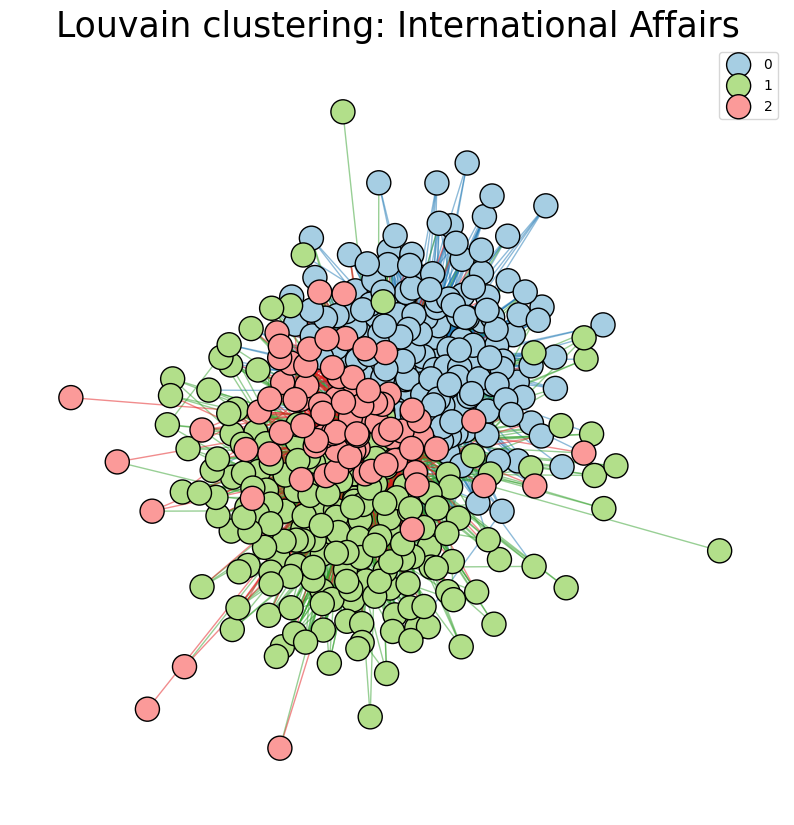

In [ ]:
# function for setting colors of nodes and edges
def get_paired_color_palette(size):
    palette = []
    for i in range(size*2):
        palette.append(plt.cm.Paired(i))
    return palette


#use louvain community detection algorithm to detect communities in G
communities =[]
louvain = cl.best_partition(G, weight = 'weight', random_state = 42)
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    communities.append(nodelist)

#sort communities by length of community
communities.sort(key = lambda x: len(x), reverse = True)

#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)[0::2]
dark_colors = get_paired_color_palette(clusters_count)[1::2]
g = nx.drawing.layout.spring_layout(G, weight = 'weight', threshold = .0000000001)

for i in range(len(communities)):
    nodelist = communities[i]
    edgelist = [e for e in G.edges if (e[0] or e[1]) in nodelist]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

plt.title('Louvain clustering: International Affairs', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
community_members = defaultdict()
community_bills = defaultdict()

for i in range(3):
    dic ={}
    index = []
    #set community_of_interest
    community_of_interest = i

    #create subgraph with nodes limited to the community_of_interest
    subgraph = MD.subgraph(communities[community_of_interest])

    #sort members of community_of_interest by in_degree centality
    community_df = pd.DataFrame.from_dict(nx.algorithms.centrality.in_degree_centrality(subgraph), orient = 'index', columns = ['centrality']).merge(members[['name','current_party', 'committee_assignments']], how = 'left', left_index = True, right_index = True).sort_values(by= 'centrality',ascending = False)
    community_members[i] = community_df

    # Tally bills in subgraph of community using a dictionary having keys of associated bills
    for u,v,d in subgraph.edges(data = True):
        if d['bill'] not in index:
            index.append(d['bill'])
        if d['bill'] not in dic:
            dic[d['bill']] = 1
        else:
            dic[d['bill']] += 1

    #create data frame from dic and sort by tally in descending order
    community_bills[i] = pd.DataFrame.from_dict(dic, orient = 'index',columns = ['tally']).sort_values(by = 'tally', ascending = False).merge(bills['title'],how = 'left', left_index =True, right_index= True)

In [ ]:
l = []
index = []

for i in range(3):

    community_i  = i
    democrats = len(community_members[community_i].loc[community_members[community_i].current_party == 'Democratic'])
    republicans = len(community_members[community_i].loc[community_members[community_i].current_party == 'Republican'])
    independents = len(community_members[community_i].loc[community_members[community_i].current_party == 'Independent'])

    total_members = len(community_members[community_i])

    total_bills = len(community_bills[community_i])

    l.append([democrats, republicans, independents, total_members, total_bills])

    index.append('community_' +str(i))





df = pd.DataFrame(l, columns = ['democrats', 'republicans', 'independents', 'total_members', 'total_bills'],index = index)
df.head()

,democrats,republicans,independents,total_members,total_bills
community_0,176,2,1,179,117
community_1,15,164,0,179,66
community_2,47,36,0,83,139


In [ ]:
pd.concat([community_members[0].head(10), community_members[1].head(10), community_members[2].head(10)], keys =
         ['community_0', 'community_1', 'community_2'])

centrality               name current_party  \
community_0 L000579    1.511236     alan-lowenthal    Democratic   
            L000480    1.050562         nita-lowey    Democratic   
            L000551    1.011236        barbara-lee    Democratic   
            F000462    0.887640       lois-frankel    Democratic   
            C001084    0.876404    david-cicilline    Democratic   
            M000312    0.735955     james-mcgovern    Democratic   
            L000582    0.696629           ted-lieu    Democratic   
            K000389    0.662921          ro-khanna    Democratic   
            C001101    0.657303    katherine-clark    Democratic   
            B001270    0.595506         karen-bass    Democratic   
community_1 D000610    0.910112    theodore-deutch    Democratic   
            S001190    0.893258  bradley-schneider    Democratic   
            L000562    0.595506      stephen-lynch    Democratic   
            C001109    0.561798         liz-cheney    Republican   
            B001302    0.426966         andy-biggs    Republican   
            M001177    0.415730     tom-mcclintock    Republican   
            G000579    0.348315     mike-gallagher    Republican   
            C001062    0.241573          k-conaway    Republican   
            M001198    0.230337     roger-marshall    Republican   
            H001072    0.207865             j-hill    Republican   
community_2 E000179    3.804878        eliot-engel    Democratic   
            S000522    1.134146  christopher-smith    Republican   
            M001157    1.109756     michael-mccaul    Republican   
            S000344    0.451220       brad-sherman    Democratic   
            K000375    0.439024    william-keating    Democratic   
            W000795    0.426829         joe-wilson    Republican   
            C001078    0.378049    gerald-connolly    Democratic   
            F000449    0.365854   jeff-fortenberry    Republican   
            S001165    0.329268        albio-sires    Democratic   
            Y000065    0.304878           ted-yoho    Republican   

                                                 committee_assignments  
community_0 L000579  [Natural Resources, Transportation and Infrast...  
            L000480                            [Appropriations, Chair]  
            L000551                           [Appropriations, Budget]  
            F000462                                   [Appropriations]  
            C001084                       [Foreign Affairs, Judiciary]  
            M000312                        [Rules, Chair, Agriculture]  
            L000582                       [Foreign Affairs, Judiciary]  
            K000389     [Armed Services, Budget, Oversight and Reform]  
            C001101                                   [Appropriations]  
            B001270                       [Foreign Affairs, Judiciary]  
community_1 D000610        [Ethics, Chair, Foreign Affairs, Judiciary]  
            S001190                   [Small Business, Ways and Means]  
            L000562  [Financial Services, Oversight and Reform, Tra...  
            C001109                [Armed Services, Natural Resources]  
            B001302        [Judiciary, Science, Space, and Technology]  
            M001177                     [Judiciary, Natural Resources]  
            G000579  [Armed Services, Transportation and Infrastruc...  
            C001062  [Agriculture, Armed Services, Permanent Select...  
            M001198      [Agriculture, Science, Space, and Technology]  
            H001072                               [Financial Services]  
community_2 E000179      [Foreign Affairs, Chair, Energy and Commerce]  
            S000522                                  [Foreign Affairs]  
            M001157               [Foreign Affairs, Homeland Security]  
            S000344  [Financial Services, Foreign Affairs, Science,...  
            K000375                  [Armed Services, Foreign Affairs]  
            W0

In [ ]:
pd.concat([community_bills[0].head(10), community_bills[1].head(10), community_bills[2].head(10)], keys =
         ['community_0', 'community_1', 'community_2'])

tally  \
community_0 H.Res.326       152   
            H.R.1055        149   
            H.R.1581        117   
            H.Res.296        95   
            H.R.4722         88   
            H.R.1857         82   
            H.J.Res.37       79   
            H.R.1274         75   
            H.R.2354         74   
            H.R.2829         71   
community_1 H.Res.246       158   
            H.R.1837        134   
            H.R.587         106   
            H.R.4692         94   
            H.Con.Res.58     75   
            H.Res.374        74   
            H.R.1372         50   
            H.Res.189        41   
            H.Res.49         37   
            H.R.2790         34   
community_2 H.R.649          33   
            H.R.4695         33   
            H.Res.259        30   
            H.J.Res.77       28   
            H.Res.220        26   
            H.R.31           25   
            H.R.2615         25   
            H.Res.222        24   
            H.R.221          24   
            H.R.3190         21   

                                                                      title  
community_0 H.Res.326     Expressing the sense of the House of Represent...  
            H.R.1055      To prohibit the application of certain restric...  
            H.R.1581      To amend the Foreign Assistance Act of 1961 to...  
            H.Res.296     Affirming the United States record on the Arme...  
            H.R.4722      To authorize contributions to the United Natio...  
            H.R.1857      To establish in the Bureau of Democracy, Human...  
            H.J.Res.37    Directing the removal of United States Armed F...  
            H.R.1274                           To repeal Public Law 107-40.  
            H.R.2354      To limit the use of funds for kinetic military...  
            H.R.2829      To clarify that Congress has not provided auth...  
community_1 H.Res.246     Opposing efforts to delegitimize the State of ...  
            H.R.1837      To make improvements to certain defense and se...  
            H.R.587       To posthumously award the Congressional Gold M...  
            H.R.4692      To impose sanctions with respect to Turkey, an...  
            H.Con.Res.58  Commemorating the 35th anniversary of the Mexi...  
            H.Res.374     Condemning Iranian state-sponsored terrorism a...  
            H.R.1372      To clarify that it is United States policy to ...  
            H.Res.189     Recognizing the importance of sustained United...  
            H.Res.49                 Supporting Coptic Christians in Egypt.  
            H.R.2790      To make additional financial assets of the Gov...  
community_2 H.R.649       To condemn gross human rights violations of et...  
            H.R.4695      To impose sanctions with respect to Turkey, an...  
            H.Res.259     Expressing the sense of the House of Represent...  
            H.J.Res.77    Opposing the decision to end certain United St...  
            H.Res.220     Recognizing the interdependence of diplomacy, ...  
            H.R.31        To require certain additional actions in conne...  
            H.R.2615      To support the people of Central America and s...  
            H.Res.222     Emphasizing the importance of alliances and pa...  
            H.R.221       To amend the State Department Basic Authoritie...  
            H.R.3190      To authorize humanitarian assistance and impos...

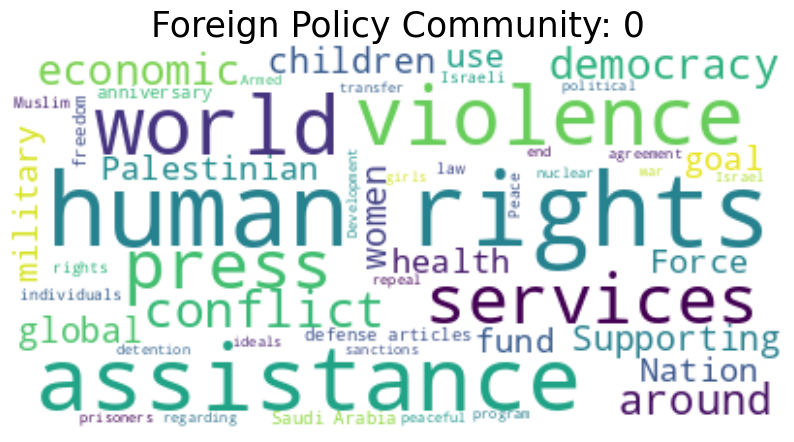

In [ ]:
plot_wordcloud(bills, community_bills[0].index, '0')

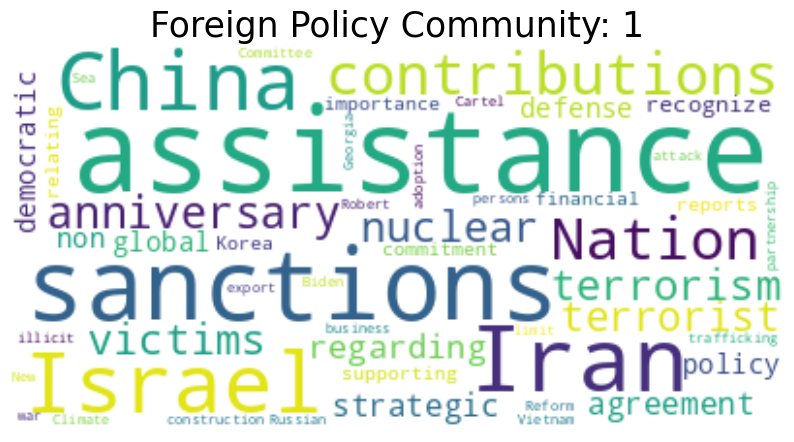

In [ ]:
plot_wordcloud(bills, community_bills[1].index, '1')

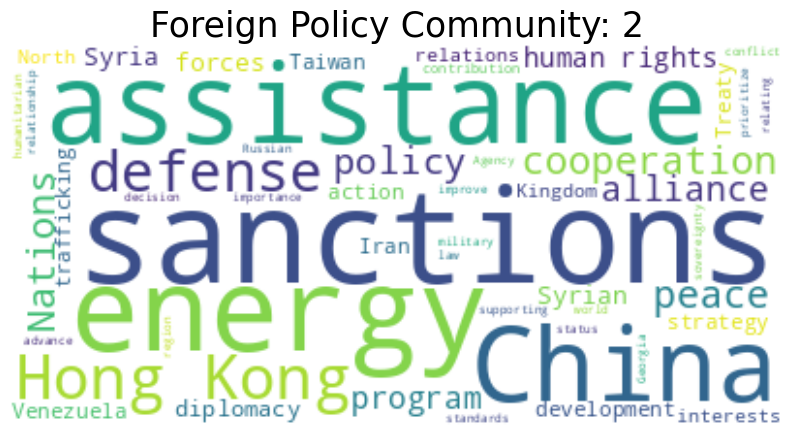

In [ ]:
plot_wordcloud(bills, community_bills[2].index, '2')